### Initialization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.spatial import cKDTree
from scipy.io import wavfile        # To read and write .wav files
from IPython.display import Audio   # To play audio in the notebook 
from ipywidgets import interact
from falconn import LSHIndex, Queryable, LSHConstructionParameters, DistanceFunction, LSHFamily, StorageHashTable
from scipy.signal import medfilt


In [2]:
vector_length = 350
stride = 5
samplingrate = 22050
hopsize = 220

In [3]:
datasetpath = "trueMidi/pitchestimates"
# for track in os.listdir(datasetpath):
#     if(track[len(track)-3:]== "npy"):
#         dirlist.append(track[:track.rfind('.')])

dirlist = ['000460', '000110', '000070', '000270', '000310', '000300', '000260', '000060', '000100', '000470']    
print(dirlist)

['000460', '000110', '000070', '000270', '000310', '000300', '000260', '000060', '000100', '000470']


### Some helper functions

In [4]:
#given a midi-sequence return the notes in the sequence and their onsets and offsets
def note_sequence(MIDI_sequence, epsilon=0.1): 
    onset = []
    offset = []
    note_pitch = []
    if(len(MIDI_sequence) == 0):
        return onset, offset, note_pitch
    note_pitch.append(MIDI_sequence[0])


    onset.append(0)
    prev_pitch = MIDI_sequence[0]

    for pitch_index in range(1,len(MIDI_sequence)):
        pitch = MIDI_sequence[pitch_index]
        
        if abs(pitch - prev_pitch) > epsilon:
            onset.append(pitch_index)
            offset.append(pitch_index)
            note_pitch.append(MIDI_sequence[pitch_index])

        prev_pitch = pitch

    offset.append(len(MIDI_sequence))

    return onset, offset, note_pitch

#returns a normalized midi_sequence
def freq_normalisation(MIDI_sequenceold): 

    onset, offset, note_pitch = note_sequence(MIDI_sequenceold)
    
    onset_times = [i*np.float(hopsize)/samplingrate for i in onset]
    offset_times = [i*np.float(hopsize)/samplingrate for i in offset]

    onset_times = np.asarray(onset_times)
    offset_times = np.asarray(offset_times)

    weights = offset_times - onset_times
    Average = np.sum(np.multiply(note_pitch,weights))/offset_times[-1]

    note_pitch = note_pitch - Average
    
    MIDI_sequence = []
    
    for i in range(len(note_pitch)):
        MIDI_sequence[onset[i]:offset[i]] = [note_pitch[i]]*(offset[i]-onset[i])
    
    return MIDI_sequence



### Creating the database

In [5]:
pitch_vectorDBfinal = np.zeros((1,vector_length))
pitchvector_indexfinal = [["New",0]]
for track_name in dirlist:
    pitch_vectorDB = np.zeros((1,vector_length))
    pitchvector_index = [["Null",0]]
    
    # load the pitch estimates generated by generatePitchEstimates.ipynb
    [note_pitches,onset,offset] = np.load(datasetpath + '/' + track_name + '.npy')
    
    MIDI_sequence = []
    
    offsetint = offset.astype(int)
    onsetint = onset.astype(int)
    
    #create a sequence of midi notes from the pitch estimates
    for i in range(len(note_pitches)):
        MIDI_sequence[onsetint[i]:offsetint[i]] = [note_pitches[i]]*(offsetint[i]-onsetint[i]) 
     
    #normalize the sequence
    MIDI_sequence = freq_normalisation(MIDI_sequence)
    
    
    num_of_pitch_vectors = int((len(MIDI_sequence) - vector_length)/stride)

    #generate the pitch vectors as described in the presentation and append them to database
    for i in range(num_of_pitch_vectors):
        time = i*np.float(hopsize)/samplingrate
        pitch_vector = freq_normalisation(MIDI_sequence[stride*i:stride*i+vector_length])
        pitch_vectorDB = np.concatenate((pitch_vectorDB,np.matrix(pitch_vector)),axis=0)
        pitchvector_index.append([track_name,time])
    
    pitch_vectorDBfinal = np.concatenate((pitch_vectorDBfinal,pitch_vectorDB),axis=0)
    pitchvector_indexfinal = pitchvector_indexfinal + pitchvector_index



### MIDI extraction from query using pyin

In [6]:
#extract midi from wav file using pyin
def MIDIextraction(audio_file):
    sample_rate = 22050
    hop_length = sample_rate//100                               # 10 msec
    win_length = hop_length * 4
    n_fft = 2**(int(np.ceil(np.log2(win_length))))  
    audio, sample_rate = librosa.load(
        path = audio_file,
        sr = sample_rate,
        mono = True
    )
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y = audio,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        sr = sample_rate,

        # STFT parameters for spectrogram
        hop_length = hop_length,
        win_length = win_length,
        frame_length = n_fft,
        fill_na = 0             # Default is np.nan, if kept as np.nan, saving the sine audio file later will encounter issues
    )
    times = librosa.times_like(f0, sr = sample_rate, hop_length = hop_length, n_fft = n_fft)


    count = 0
    gap_time = 0.25/(hop_length/sample_rate) # 250 ms
    value = 0
    f0_new = f0
    for i in range(len(f0)):
        if(f0[i]==0):
            count+=1
        else:
            if(count>=gap_time):
                count = 0
            else:
                f0_new[i-count:i] = np.ones(count)*value
                count = 0
                value = 0
    #     if(i!=len(f0)-1 and f0[i+1]==0 and count==0):
            value = f0[i]
    f0 = f0_new

    from scipy.ndimage import gaussian_filter1d
    sigma = 0.5
    f0_GS = gaussian_filter1d(f0_new, sigma)

    queryMIDISeq = librosa.hz_to_midi(f0_GS)

    queryMIDISeq[queryMIDISeq<0] = 0

    queryMIDISeq = np.trim_zeros(queryMIDISeq)
    # 
    # curnote = round(queryMIDISeq[0])

    # # lastnonzero = queryMIDISeq[0]
    for i in range(len(queryMIDISeq)):
        queryMIDISeq[i] = round(queryMIDISeq[i])
    
    return queryMIDISeq


### Some more helper functions

In [7]:
def time(pitch_index):

    return (pitch_index*np.float(hopsize)/samplingrate)

#for matching tempo, given pitch estimates, it increases and decreases tempo from 0.5x to 1.5x
def get_list_of_elongated_pitch_estimates(pitch_estimates, size_n=10, epsilon=0.1): #Done

    onset, offset, note_pitch = note_sequence(pitch_estimates, epsilon)
    onset = np.asarray(onset)
    offset = np.asarray(offset)

    list_of_elongated_MIDI_sequence = []

    for i in range(size_n+1):

        w = 0.5 + 0.1*i

        onset_scaled = onset*w
        offset_scaled = offset*w

        onset_scaled = np.asarray(onset_scaled,dtype=int)
        offset_scaled = np.asarray(offset_scaled,dtype=int) 
        
        
        new_pitch_estimates = []
        for j in range(len(note_pitch)):
            new_pitch_estimates[onset_scaled[j]:offset_scaled[j]] = [note_pitch[j]]*(offset_scaled[j]-onset_scaled[j])
        list_of_elongated_MIDI_sequence.append([new_pitch_estimates,w])

    return list_of_elongated_MIDI_sequence



In [8]:
tree = cKDTree(pitch_vectorDBfinal, leafsize=100)


def getSong(queryMIDISeq):
    currmin = 100000000
    ans = 0
    fq = []
    fstride= 0

    scaled_pitch_estimate_matrix = get_list_of_elongated_pitch_estimates(queryMIDISeq)
    candidate_segment_list = []

    result_list = []
    for [pitch_estimates,scale] in scaled_pitch_estimate_matrix:

        query_pitch_matrix = np.matrix(pitch_estimates[0:vector_length])
        num_of_pitch_vectors = int((len(pitch_estimates)-vector_length)/stride)
        query_times = [0]
        for i in range(1,num_of_pitch_vectors):
            query_pitch_matrix = np.concatenate((query_pitch_matrix,np.matrix(pitch_estimates[stride*i:stride*i+vector_length])),axis=0)
            time = i*stride*np.float(hopsize)/samplingrate
            query_times.append(time)


        for i in range(num_of_pitch_vectors):
            query = query_pitch_matrix[i]
            q = np.copy(query)
            q = np.squeeze(q)
            q = freq_normalisation(q)
            q = np.asarray(q,dtype=np.float64)

            TheResult = tree.query(q, k=1, distance_upper_bound=10000)
            if(TheResult[0] < currmin):
                fq = q
                ans = TheResult[1]
                currmin = TheResult[0]
                fstride = scale
    return ans


### Results

00027.wav


/Users/vatsalgoyal/Downloads//envs/FMP/lib/python3.7/site-packages/librosa/core/convert.py:742: RuntimeWarning: divide by zero encountered in log2
  return 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


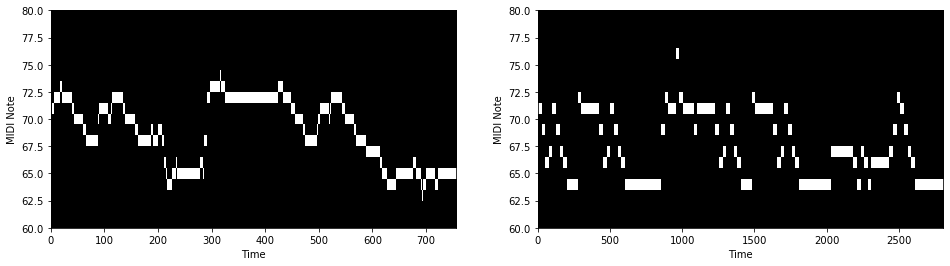

00027.wav 000270
00026.wav


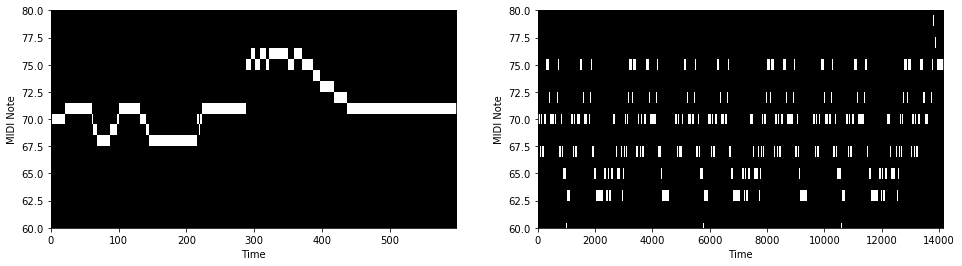

00026.wav 000260
00030.wav


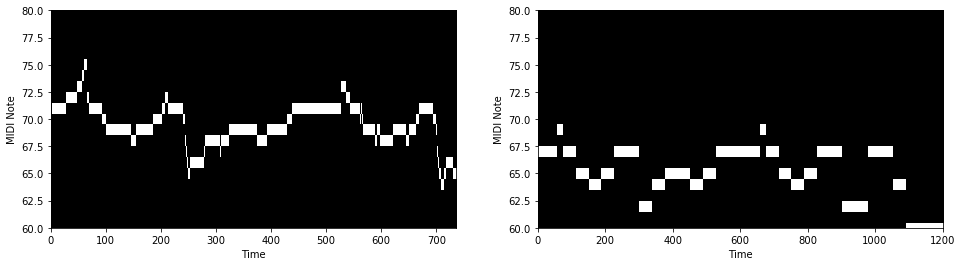

00030.wav 000300
00031.wav


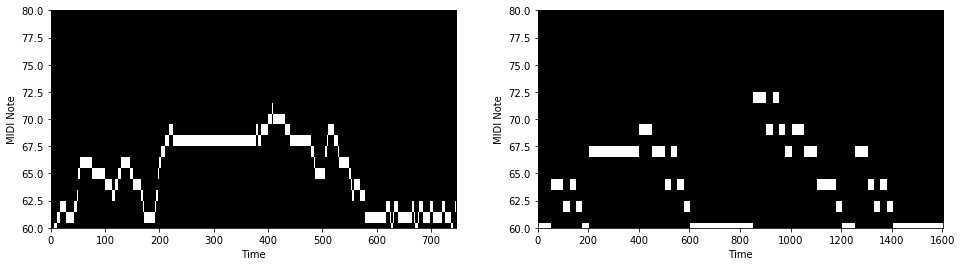

00031.wav 000260
00047.wav


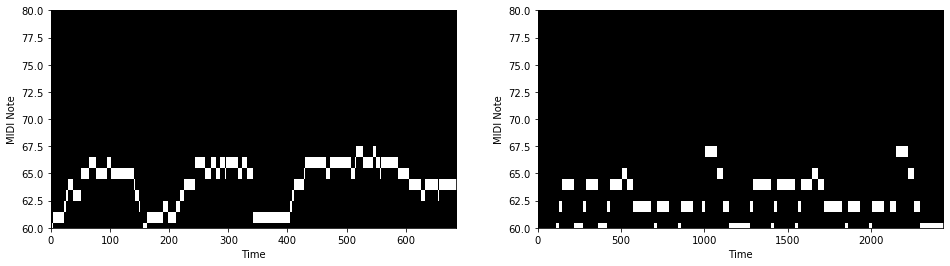

00047.wav 000460
00046.wav


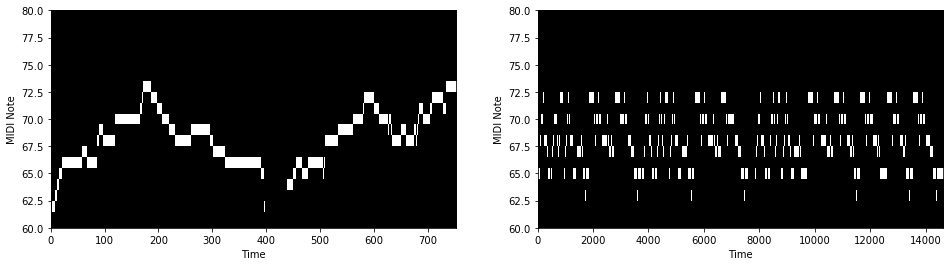

00046.wav 000460
00006.wav


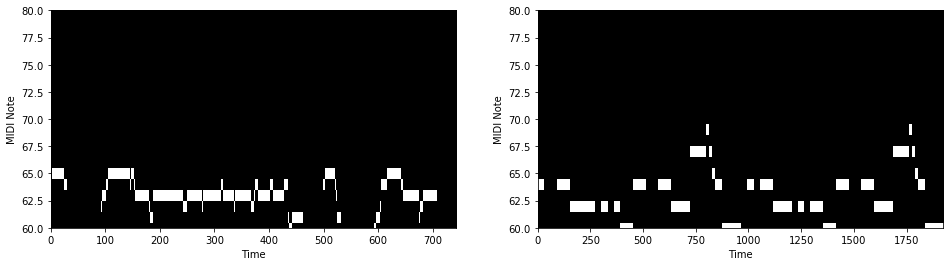

00006.wav Null
00007.wav


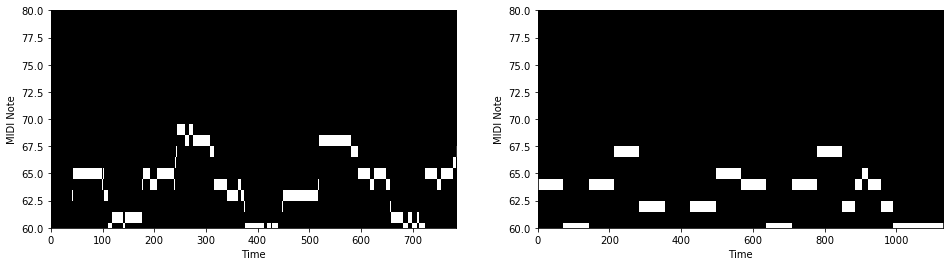

00007.wav 000070
00011.wav


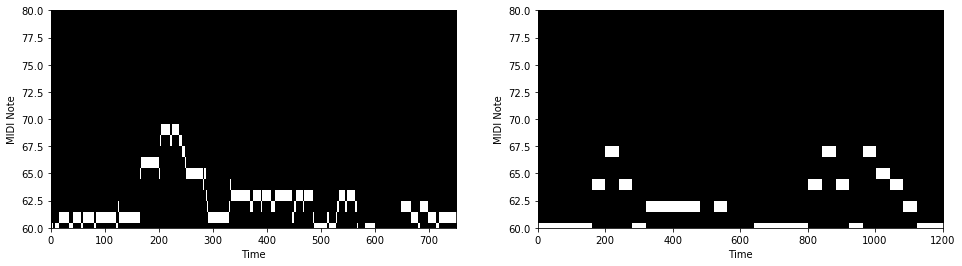

00011.wav 000110
00010.wav


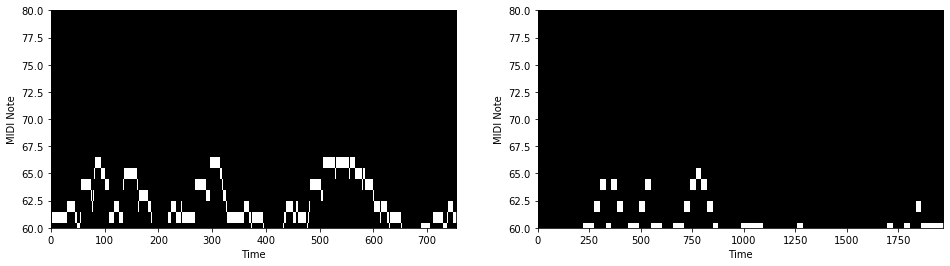

00010.wav 000100


In [9]:
querypath = "./queries/waveFile/year2008/person00002"
for i in range(1):
#     print(dir)
#     if(os.path.isdir(os.path.join(querypath, dir))== False):
#         continue
    for track in os.listdir(querypath):
        if(track[len(track)-3:]== "wav" and track[:len(track)-4]+"0" in dirlist):
            print(track)
            queryMIDISeq = MIDIextraction(querypath + "/" + track)
            onset, offset, pitch = note_sequence(queryMIDISeq+1)
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            # Create a matrix representing the piano roll
            piano_roll = np.zeros((128, len(queryMIDISeq)))
            for i, note in enumerate(pitch):
                piano_roll[int(note)][onset[i]:offset[i]] = 1

            # Plot the piano roll
            axs[0].imshow(piano_roll, aspect='auto', origin='lower', cmap='gray')

            # Set the x-axis and y-axis labels
            axs[0].set_xlabel('Time')
            axs[0].set_ylabel('MIDI Note')

            # Set the y-axis limits to cover the full range of MIDI notes
            axs[0].set_ylim(60, 80)

            # Show the plot
            
            [note_pitches,onset,offset] = np.load(datasetpath + '/' + track[:-4] + '0.npy')
 
            piano_roll = np.zeros((128, int(offset[-1])+1))
            for i, note in enumerate(note_pitches):
                piano_roll[int(note)][int(onset[i]):int(offset[i])] = 1

            # Plot the piano roll
            axs[1].imshow(piano_roll, aspect='auto', origin='lower', cmap='gray')

            # Set the x-axis and y-axis labels
            axs[1].set_xlabel('Time')
            axs[1].set_ylabel('MIDI Note')

            # Set the y-axis limits to cover the full range of MIDI notes
            axs[1].set_ylim(60, 80)

            # Show the plot
            plt.show()

            ans = getSong(queryMIDISeq)
            print(track, pitchvector_indexfinal[ans][0])

00027.wav


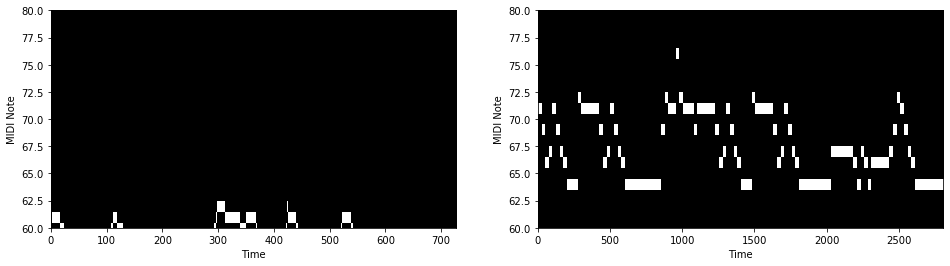

00027.wav 000100
00030.wav


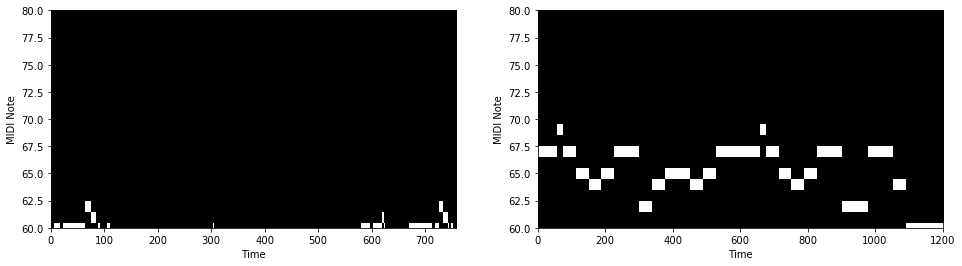

00030.wav 000460
00031.wav


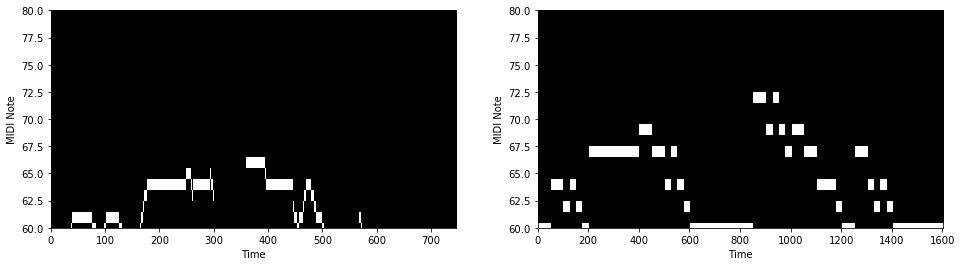

00031.wav 000310
00046.wav


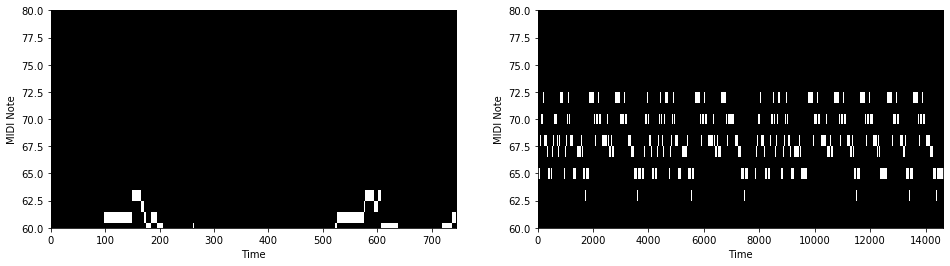

00046.wav 000460
00011.wav


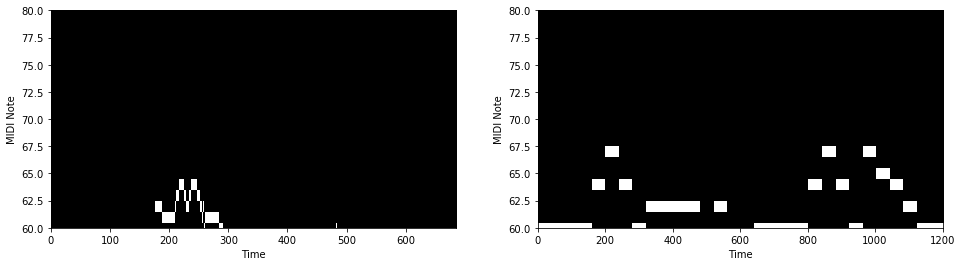

00011.wav 000460
00010.wav


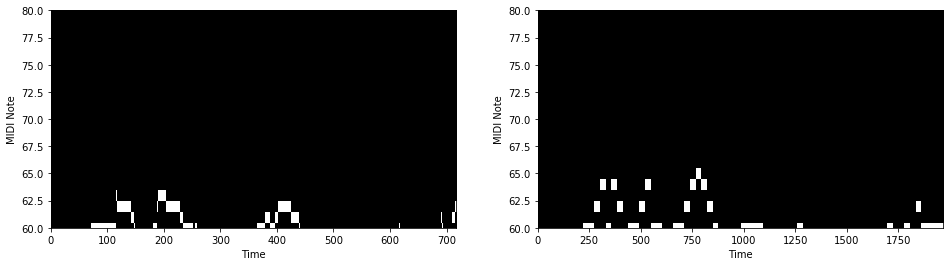

00010.wav 000460


In [10]:
querypath = "./queries/waveFile/year2008/person00001"
for i in range(1):
#     print(dir)
#     if(os.path.isdir(os.path.join(querypath, dir))== False):
#         continue
    for track in os.listdir(querypath):
        if(track[len(track)-3:]== "wav" and track[:len(track)-4]+"0" in dirlist):
            print(track)
            queryMIDISeq = MIDIextraction(querypath + "/" + track)
            onset, offset, pitch = note_sequence(queryMIDISeq+1)
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            # Create a matrix representing the piano roll
            piano_roll = np.zeros((128, len(queryMIDISeq)))
            for i, note in enumerate(pitch):
                piano_roll[int(note)][onset[i]:offset[i]] = 1

            # Plot the piano roll
            axs[0].imshow(piano_roll, aspect='auto', origin='lower', cmap='gray')

            # Set the x-axis and y-axis labels
            axs[0].set_xlabel('Time')
            axs[0].set_ylabel('MIDI Note')

            # Set the y-axis limits to cover the full range of MIDI notes
            axs[0].set_ylim(60, 80)

            # Show the plot
            
            [note_pitches,onset,offset] = np.load(datasetpath + '/' + track[:-4] + '0.npy')
 
            piano_roll = np.zeros((128, int(offset[-1])+1))
            for i, note in enumerate(note_pitches):
                piano_roll[int(note)][int(onset[i]):int(offset[i])] = 1

            # Plot the piano roll
            axs[1].imshow(piano_roll, aspect='auto', origin='lower', cmap='gray')

            # Set the x-axis and y-axis labels
            axs[1].set_xlabel('Time')
            axs[1].set_ylabel('MIDI Note')

            # Set the y-axis limits to cover the full range of MIDI notes
            axs[1].set_ylim(60, 80)

            # Show the plot
            plt.show()

            ans = getSong(queryMIDISeq)
            print(track, pitchvector_indexfinal[ans][0])